In [ ]:
!pip install d2l
!pip install matplotlib==3.0.0
import torch
import numpy as np
import pandas as pd
from torch import nn
from d2l import torch as d2l

In [ ]:
# 读取数据集(训练集和测试集)

train_data = pd.read_csv(r'/content/sample_data/california_housing_test.csv', encoding='utf-8')
test_data = pd.read_csv(r'/content/sample_data/california_housing_train.csv', encoding='utf-8')

# 整合训练集和测试集方便进行数据预处理
all_features = pd.concat((train_data.iloc[:, :-1], test_data.iloc[:, :]))

# 数据预处理
# 将所有缺失值替换为相应特征的平均值，再标准化数据（x = (x - μ）/ ρ），其中μ表示均值，ρ表示标准差
# 标准化的好处是数据均值变为0

# 找出所有数值数据的index
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 标准化数值数据
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 标准化数值数据之后，所有单项数值数据均值为0，可以将数值数据的缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 将所有非数值数据的‘na’更改为True
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(20000, 9)


In [ ]:
# 离散测试集和数据集
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.median_house_value.values.reshape(-1, 1), dtype=torch.float32
)

In [ ]:
# 定义损失函数和模型
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  # nn.Linnear()参数分别为上层神经元个数，本层神经元个数，权重，偏置值
  net = nn.Sequential(nn.Linear(in_features, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1)) 
  return net


\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.

In [ ]:
# 因为不同地区的房价不相同，预测值和真实价格的差异应该考虑相对误差
def log_rmse(net, features, labels):
  # 将预测值的区间变为[1，∞),方便进行log计算
  clipped_preds = torch.clamp(net(features), 1, float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
  return rmse.item()

In [ ]:
# Adam优化器，使得对初始学习率不那么敏感
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # 使用Adam优化算法
  optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward() # 求解梯度
      optimizer.step() # 权重更新
    train_ls.append(log_rmse(net, train_features, train_labels)) # 计算相对误差
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k # 向下取整的除法
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # 返回一个切片对象
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part # 划分验证集
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
# 求训练Loss和测试Loss
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.330180, 验证log rmse0.324705
折2，训练log rmse0.320125, 验证log rmse0.335433
折3，训练log rmse0.328788, 验证log rmse0.317784
折4，训练log rmse0.320426, 验证log rmse0.343408
折5，训练log rmse0.320455, 验证log rmse0.341789
5-折验证: 平均训练log rmse: 0.323995, 平均验证log rmse: 0.332624


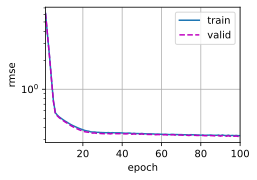

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    print(preds[:5])

训练log rmse：0.325960
[[61817.574]
 [61430.566]
 [75066.1  ]
 [83204.93 ]
 [70766.63 ]]


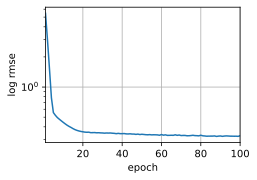

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)